1. Prepare the environment

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

2. Add Dataset

In [3]:
dataset_path = './realwaste/realwaste-main/RealWaste'

3. Split the dataset into training, validation, and testing

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize (mean, std for RGB)
])

# Load the dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split into training and validation datasets
train_size = int(0.6 * len(dataset))
test_size = int(0.2 * len(dataset))
val_size = len(dataset) - train_size - test_size
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print class names
print("Classes:", dataset.classes)


Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


4. Build the CNN model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, x1, m1, x2, m2, x3, d, K):
        super(CustomCNN, self).__init__()

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=x1, kernel_size=m1, stride=1, padding=m1 // 2)
        self.activation1 = nn.ReLU()  

        # MaxPooling Layer 1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(in_channels=x1, out_channels=x2, kernel_size=m2, stride=1, padding=m2 // 2)
        self.activation2 = nn.ReLU()  

        # MaxPooling Layer 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layer
        self.fc1 = nn.Linear(x2 * (128 // 4) * (128 // 4), x3)  # Adjust dimensions based on input size and pooling
        self.activation3 = nn.ReLU()  
        self.dropout = nn.Dropout(d)  # Dropout layer

        # Output Layer
        self.fc2 = nn.Linear(x3, K)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.activation2(x)
        x = self.pool2(x)

        x = torch.flatten(x, 1)  # Flatten the output for the fully connected layer

        x = self.fc1(x)
        x = self.activation3(x)
        x = self.dropout(x)

        x = self.fc2(x)
        return F.log_softmax(x, dim=1)  # Softmax activation

# Define the model parameters
x1, m1 = 32, 3  # Filters and kernel size for the first convolutional layer
x2, m2 = 64, 3  # Filters and kernel size for the second convolutional layer
x3 = 128        # Number of units in the fully connected layer
d = 0.5         # Dropout rate
K = len(dataset.classes)  # Number of output classes

# Instantiate the model
model = CustomCNN(x1, m1, x2, m2, x3, d, K)

# Print the model architecture
print(model)


CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (activation3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)


Check Cuda Availability and Version

In [6]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# If CUDA is available, check the PyTorch CUDA version
if cuda_available:
    print(f"CUDA version supported by PyTorch: {torch.version.cuda}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available in this PyTorch installation.")

CUDA available: False
CUDA is not available in this PyTorch installation.


7. Train & Eveluate the model


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

# Model, loss function, and optimizer
model = CustomCNN(x1, m1, x2, m2, x3, d, K)  # Define your model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LR = [0.0001, 0.001, 0.01, 0.1]
results = {}  # Dictionary to store training and validation losses for each learning rate

for lr in LR:
    print("--------------------------------")
    print(f"Learning Rate: {lr}")
    criterion = nn.CrossEntropyLoss()  # Loss function for classification
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Adam optimizer

    # Training parameters
    num_epochs = 20  # Number of epochs
    train_losses = []
    val_losses = []

    # Training and validation loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Clear gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item() * images.size(0)

            # Train Accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Calculate Train Accuracy as percentage
        train_accuracy = 100 * correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

                # Accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_accuracy = 100 * correct / total

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}% ",
              f"Validation Loss: {epoch_val_loss:.4f}, "
              f"Validation Accuracy: {val_accuracy:.2f}%")
        
    print(f"Testing for Learning Rate: {lr}")
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct / total

    print(f"Learning Rate: {lr} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


    # Save losses for this learning rate
    results[lr] = {'train_losses': train_losses, 'val_losses': val_losses}


--------------------------------
Learning Rate: 0.0001


KeyboardInterrupt: 

8. Why we have chosen adam optimizer over SGD?

The Adam optimizer is chosen because it combines the benefits of Momentum and RMSProp, making it well-suited for deep learning tasks. It dynamically adjusts the learning rate for each parameter using estimates of first and second moments of gradients, enabling faster convergence and handling sparse gradients better. In contrast, SGD with a fixed learning rate may require more manual tuning and tends to converge slower without additional techniques like momentum. For tasks like classification, where the dataset may have varying complexity, Adam provides better efficiency and performance out of the box.

9. Why we have chosen sparse categorical crossentropy as the loss function?

CrossEntropyLoss (equivalent to Sparse Categorical Crossentropy) is specifically designed for classification problems with mutually exclusive classes. It works well by comparing the predicted probability distribution over classes with the true class labels and penalizing incorrect predictions. This makes it suitable for multi-class classification tasks like this one. Its mathematical formulation inherently aligns with softmax outputs, ensuring proper gradient updates for learning discriminative features.

11. Plot Training and Validation Losses

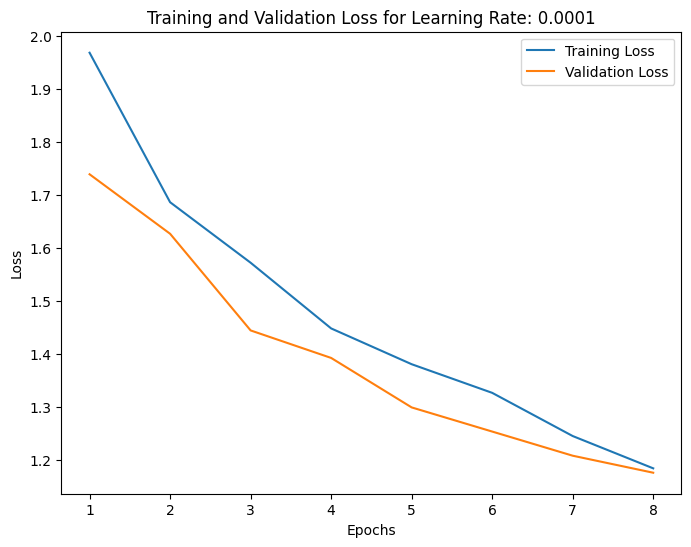

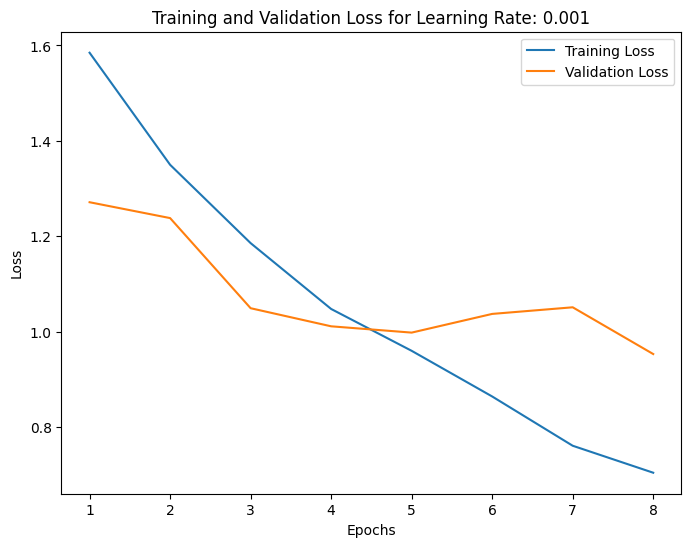

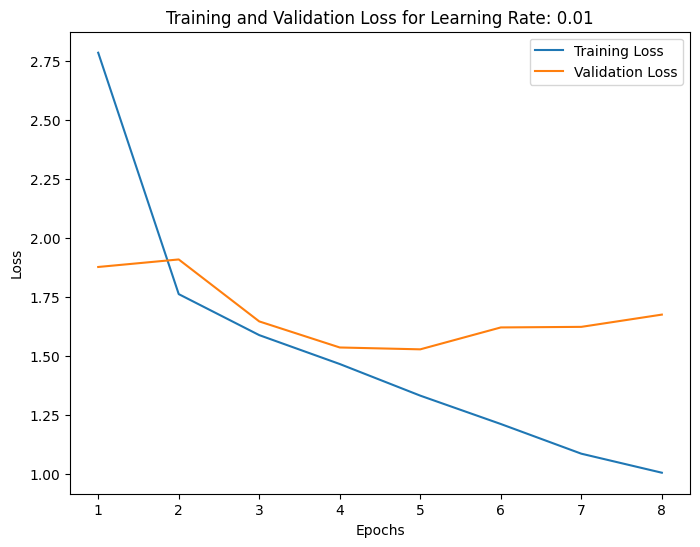

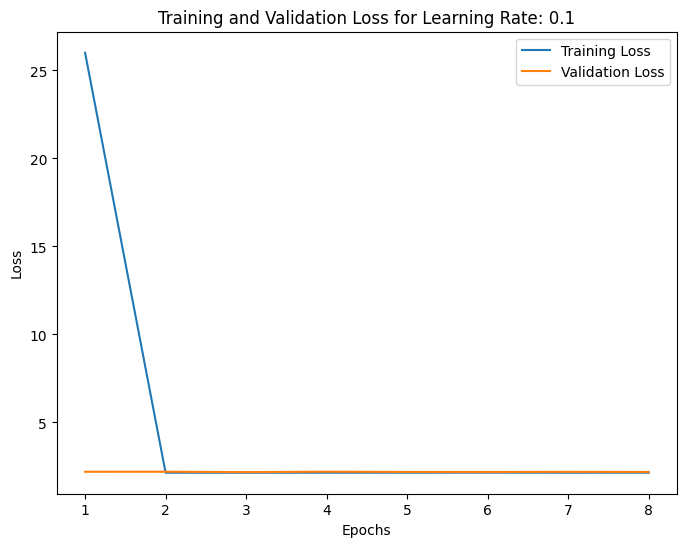

In [9]:
import matplotlib.pyplot as plt

# Plot training and validation losses for each learning rate
for lr in LR:
    train_losses = results[lr]['train_losses']
    val_losses = results[lr]['val_losses']
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training and Validation Loss for Learning Rate: {lr}')
    plt.show()
